### Introduction

In this notebook, I'll develop mathematical justification and code for estimates of the area contraction rate of the return map of the Lorenz system.

We will use the Lorenz equations in their Jordan Normal form, given by equation 2 in Tucker. Here $L$ is an operator acting on the vector $(x_1, x_2, x_3)$.

\begin{equation}
\left(
\begin{matrix}
\dot{x_1} \\ \dot{x_2} \\ \dot{x_3}
\end{matrix}
\right)
=
L
\left(
\begin{matrix}
x_1 \\ x_2 \\ x_3
\end{matrix}
\right)
=
\left(
\begin{matrix}
\lambda_1 x_1 - k_1 (x_1 + x_2) x_3 \\
\lambda_2 x_2 + k_1 (x_1 + x_2) x_3 \\
\lambda_3 x_3 + (x_1 + x_2) (k_2 x_1 + k_3 x_2)
\end{matrix}
\right)
\end{equation}

This is equivalent to the classical parameter values after a linear transformation of coordinates (see Tucker), if we set

\begin{equation}
\left(
\begin{matrix}
\lambda_1 \\ \lambda_2 \\ \lambda_3
\end{matrix}
\right)
=
\left(
\begin{matrix}
11.8 \\ -22.8 \\ -2.67
\end{matrix}
\right)
\text{   and   }
\left(
\begin{matrix}
k_1 \\ k_2 \\ k_3
\end{matrix}
\right)
=
\left(
\begin{matrix}
0.29 \\ 2.2 \\ -1.3
\end{matrix}
\right)
\end{equation}

The code below defines all the variables necessary, as well as the space derivative of those equations, $DL$.

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

l = np.array([11.8, -22.8, -2.67])
k = np.array([0.29, 2.2, -1.3])


#x is assumed to be an array with three entries
def DL(x):
    return np.array([[  l[0] - k[0]*x[2],     0 - k[0]*x[2],     0 - k[0]*(x[0] + x[1])  ],
                     [         k[0]*x[2],   l[1]+ k[0]*x[2],         k[0]*(x[0] + x[1])  ],
                     [2*k[1]*x[0] + (k[1] + k[2])*x[1], 
                      2*k[2]*x[1] + (k[1] + k[2])*x[0], 
                      l[2]
                     ]])

def L(x):
    return np.array([l[0]*x[0] - k[0]*(x[0] + x[1])*x[2],
                     l[1]*x[1] + k[0]*(x[0] + x[1])*x[2],
                     l[2]*x[2] + (x[0] + x[1])*(k[1]*x[0] + k[2]*x[1])])

fsolve(lambda x: 0 - L(x), np.array([0.2, 0.05, 27]))

array([ 0.,  0.,  0.])

### Numerics and return maps

Now, Tucker's code uses the return plane $N$ defined by $x_3 = 27$ (pg 60 in Tucker). We we will also use this convention.

Given an intial point $x$, the flow of the Lorenz map will define a trajectory as a function of later time. In other words, there is a map $\Phi (x, t)$ such that $x$ flows to $\Phi (x, t)$ at time $t$, and $\Phi (x, 0) = x$.

We can approximate $\Phi$ by numeric integration, as we will below.


What we really care about is the return map $\Theta: N \rightarrow N$. Given initial point $x \in N$, $\Theta (x)$ gives the point $\Phi(x, g(x))$, where $g(x)$ is implicitly defined as the return time.

To be consistent, we will use not just the return time, but the return time \emph{from above}; that is, the third component of $\Phi(x, g(x) - dt)$ is larger than $27$, while the the $\Phi(x, g(x) + dt)$ is smaller than 27. This will become more important when we restrict our considerations to a small rectangle within $N$.

We won't really need the propagator $\Phi$, but for reference I will write both $\Phi$ and $\Theta$ as python functions. Both optionally return the entire trajectory, which will be necessary later.

It's worth noting that storing the entire trajectory is not memory-efficient; a better program would have a single routine, and would numerically integrate any relevant variables along the trajectory as it went along. However, this makes the code dense and hard to check, and obfuscates the mathematics.

y = [-0.49811512 -2.09585612]
Return time: 0.764690703022


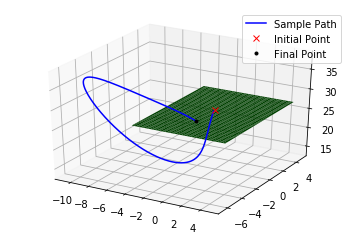

In [2]:
Nlevel = 27
dt = 0.0001

#In general, we will use the convention that y is a 2-D variable in N, while x is the original 3D vector.
#To go from y to x, we simply add the third coordinate at Nlevel.

def nextX(x, step=dt):
    """x in the next timestep.
    For now, this function is a one-liner, but we can hide
    different numerical integration conventions here in the future."""
    return x + dt*L(x)

def Phi(x, t, trace=False):
    """Track x for time t. Optionally return entire trajectory."""
    if trace:
        path = []
    tau = 0
    while tau < t:
        if trace:
            path.append(np.copy(x))
        tau += dt
        x = nextX(x)
    if trace:
        return x, path
    else:
        return x

def stopping_condition(prevStep, nextStep):
    """We've entered N from above."""
    return (prevStep[2] > Nlevel and nextStep[2] < Nlevel)

#Assumes y is 2D, in N. Returns only 2 coordinates.
def Theta(y, trace=False):
    """Track y \in N until it reaches N again."""
    if len(y) == 2:
        x = np.array([y[0], y[1], Nlevel])
    else:
        x = y
    g = 0
    if trace:
        path = [np.copy(x)]
    #This last bit is to prevent the stopping condition from immediately detecting something.
    x =nextX(x)
    nextStep = nextX(x)
    g += dt
    while not stopping_condition(x, nextStep):
        if trace:
            path.append(np.copy(x))
        x = nextStep
        nextStep = nextX(x)
        g += dt
    if trace:
        path.append(np.copy(x))
    mt = (Nlevel-x[2])/(L(x)[2])
    g += mt
    x += L(x)*mt
    if trace:
        path.append(x)
        return x[:2], g, path
    else:
        return x[:2], g


#Just some demo code
    
y, t, p = Theta((-0.5, 0.3), True)
print "y = " + str(y)
print "Return time: " + str(t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot([x[0] for x in p], [x[1] for x in p], [x[2] for x in p], 'b-', label="Sample Path")
ax.plot([-0.5], [0.5], [Nlevel], 'rx', label="Initial Point")
ax.plot([y[0]], [y[1]], [Nlevel], 'k.', label="Final Point")

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = 0*X + 27
ax.plot_surface(X, Y, Z, color='g')

ax.legend()
plt.show()

### Calculating the differential

If we want to keep track of area contraction, or of expanding / contracting directions, we need $D\Theta$.

There is a small inaccuracy in the following discussion. In principle, $Theta: \mathbb{R}^2 \rightarrow \mathbb{R}^2$. However, we will express its 2x2 Jacobian in terms of 3x3 vectors. Therefore, it is useful to imagine that we extended the domain of $\Theta$ and $g$ into some positive-measure neighborhood of the plane $N$.

Recall $\Theta(x) = \Phi(x, g(x))$. From here, 

\begin{equation}
D \Theta  = D\Phi + \partial_t \Phi \otimes \overrightarrow{\nabla} g
\end{equation}
where $\otimes$ denotes the outer product, as if $\partial_t \Phi$ is a column vector and $\overrightarrow{\nabla} g$ is a row vector. Each of these is evaluated at position $x$ and time $g(x)$.

This is a wonderful equation, but how do we numerically calculate any of the coefficients involved?

To start, notice that 

\begin{equation}
\partial_t\Phi (x, g(x)) = L(x_f)
\end{equation}
where we use $x_f = \Theta(x) = \Phi(x, g(x))$ to just denote the final point of the trajectory. For convenience, we will drop the $x_f$, and just remember to evaluate $L$ at the final point, while evaluating everything else at the initial $x$.

Next, we will handle the $\overrightarrow{\nabla} g$. At first, this seems like it might require detailed numerical calculation, but we are saved by constraints on $\Theta$.

Recall, $\Theta$ is defined as an operator that takes the plane $N$ into itself. Therefore, no horizontal variaton in initial conditions can result in a different vertical position. In other words, 
$D\Theta_{31} \equiv D\Theta_{32} \equiv 0$. Another way to put this is that $D\Theta$ has the form
\begin{equation}
\left(
\begin{matrix}
\star && \star && - \\
\star && \star && - \\
0     &&   0   && 1
\end{matrix}
\right)
\end{equation}
where $\star$ denotes the useful terms, $-$ denotes other terms we can choose an arbitrary convention for.

The third column is not important for the final result, and only has to do with our local extension of $\Theta$ into the third dimension. I chose the convention $D\Theta_{33} \equiv 1$ because this makes the determinant of the "2D $D\Theta$" and the "3D $D\Theta$" equivalent.

This gives us a very easy way to find $\overrightarrow{\nabla} g$:
\begin{equation}
\overrightarrow{\nabla} g = 
\left( \frac{1}{L_3} \right)
\left(
\begin{matrix}
-D\Phi_{31} && 
-D\Phi_{32} &&
1-D\Phi_{33}
\end{matrix}
\right)
\end{equation}
Recall that $g$ was defined implicitly in terms of properties of $\Theta$, so this is a very natural choice.

So, let us rewrite the original equation in terms of what we now know:

\begin{equation}
D \Theta  = D\Phi 
+ 
\left( \frac{1}{L_3} \right) 
L 
\otimes 
\left(
\begin{matrix}
-D\Phi_{31} && 
-D\Phi_{32} &&
1-D\Phi_{33}
\end{matrix}
\right)
\end{equation}

We have reduced the problem to computing $L$ and $D\Phi$. We already have a closed formula for $L$; how do we numerically compute $D\Phi$?

### Calculating $D\Phi $

First, notice that $D\Phi |_{t=0} \equiv \mathbb{1}$, where $\mathbb{1}$ denotes the identity matrix. If we start at point $x + dx$, and flow for $0$ time, we are still at $x + dx$.

Next, we might ask, what is $d_t D\Phi$? Again, assume we start at $x + dx$. After some time $t$, we are at point 
\begin{equation}
\Phi\vert_{x, t} + D\Phi|_{x, t}dx
\end{equation}

After time $dt$, the first-order differences in velocity $DL$ will cause additional, small drift, arriving at the point
\begin{equation}
\Phi(x, t+dt) + 
\big(
D\Phi\vert_{x, t} + dt DL|_{\Phi(x, t)}\cdot D\Phi|_{x, t}
\big)dx
\end{equation}
From the definition of $D\Phi$, this is the same as 
\begin{equation}
\Phi|_{x, t+dt} + D\Phi|_{x, t+dt}dx
\end{equation}
which finally gives
\begin{equation}
d_t D\Phi|_{x, t} = DL|_{\Phi(x, t)}\cdot D\Phi|_{x, t}
\end{equation}
Using the convention that $L$ is always evaluated at the $final$ point, while $\Phi$ is an operator on the $initial$ point, we can rewrite this as
\begin{equation}
d_t D\Phi = DL\cdot D\Phi
\end{equation}

An alternative, integral formulation is
\begin{equation}
D\Phi = \mathbb{1} + \int_0^t DL \cdot D\Phi ds
\end{equation}
with the shorthand $DL = DL(\Phi(x, s))$ and $D\Phi = D\Phi(x, t)$ on the LHS and $D\Phi(x, s)$ on the RHS.

In principle we now have a form which is ready for numerical integration, which is precisely what we will do in the next section.

It is worth noting that $D\Phi$ is the ordered exponential of $DL$. There exist more sophisticated techniques for taking ordered exponentials, such as the Magnus expansion, which unfortunately gets very numerically expensive very fast. It's possible I'll revisit that technique at a later time.

However, in the even that $DL$ is nearly constant for a long time $\tau$ along some trajectory (for instance, if we pass near a fixed point), then $D\Phi$ acquires a far simpler form: $D\Phi = e^{\tau DL}$. This form can immediately be resolved with Sylvester's formula, or, in the case of diagonal $DL$, simply by exponentiating each of the eigenvalues.

In [3]:
#Here, we produce functions for computing $D\Phi$ and $D|Theta$ along trajectories

#I left the test routines in and commented them out, to allow easy testing later.

def next_DPhi(DPhi, prevX, nextX, step=dt):
    """Again, we hide the specific form of numerical integration here.
    Note that we are using a different convention than before."""
    return DPhi + 0.5*step*np.matmul((DL(prevX) + DL(nextX)),DPhi)

def path_DPhi(path, time):
    """Takes a numerical integral to evaluate DPhi over some path."""
    DPhi = np.identity(3)
    i = 0
    l = len(path) - 1
    while i < l:
        DPhi = next_DPhi(DPhi, path[i], path[i + 1])
#        if i%100 == 0:
#            print DPhi
        i += 1
    #Take care of the unusual tail. 
    #This is a consequence of how we computed the return map
    mt = time - dt*(len(path) - 2) 
    DPhi = next_DPhi(DPhi, path[-2], path[-1])
    return DPhi

def path_DTheta(path, time):
    DPhi = path_DPhi(path, time)
    l = L(path[-1])
#    print l
    l = l/l[2]
    gradG = np.array([0., 0., 1.]) - DPhi[2]
#    print DPhi
#    print gradG
#    print np.outer(l, gradG)
    D3 = DPhi + np.outer(l, gradG) #the "3D" Theta
#    print D3
    return D3[:2, :2]

def vec_DTheta(y):
    y, g, path = Theta(y, True)
    return path_DTheta(path, g)


#Remember path p, time t, from the previous block?
print path_DTheta(p, t)
vec_DTheta((-0.5, 0.3))
#print DL(np.array([y[0], y[1], Nlevel]))

[[ 2.23042077 -0.82291509]
 [ 0.64691471 -0.23868662]]


array([[ 2.23042077, -0.82291509],
       [ 0.64691471, -0.23868662]])

### Simpler methods

We must also test simpler techniques to see if they line up. How about just applying the map to a nearby point? And how does that compare to our more sophisticated methods?

It turns out that the two agree to the second-third decimal place, which is a good sign. To be entirely honest, I trust the simple method better, but it will be easier to set strict bounds on the more sophisticated results later.

In [4]:
def simple_DTheta(x, epsilon=1e-4):
    dx1 = np.array([epsilon, 0])
    dx2 = np.array([0, epsilon])
    z, t = Theta(x)
    z1, t1 = Theta(x + dx1)
    z2, t2 = Theta(x + dx2)
    return np.ma.column_stack((z1 - z, z2 - z))/epsilon

print simple_DTheta((-0.5, 0.3))
DT = vec_DTheta((-0.5, 0.3))
print DT
np.linalg.eigvals(DT)

[[2.2273555899748887 -0.8222522026635204]
 [0.6436298082501679 -0.2377790432062099]]
[[ 2.23042077 -0.82291509]
 [ 0.64691471 -0.23868662]]


array([  1.99174204e+00,  -7.89105335e-06])

### Numerical games

We are now in a position to test for "typical" compression ratios, by computing the determinant of $D\Theta$, as well as testing for hyperbolicity, by testing the eigenvalues and comparing their sums.

What follows is a numerical exercise in using the functions defined above. We will find "typical" and "maximal" contraction ratios in a region bounded away from the stable manifold of the origin, as well as graph "hyperbolic", "uniformly contracting," and "uniformly expanding" regions.

In [41]:
#Functions and computation

bound = 0.001

#Can't be as precise here; too many measurements.
dt = 0.001

def hyperbolicity(y, DT = None):
    """2 if expanding, 0 if contracting, 1 if hyperbolic"""
    if type(DT) == type(None):
        DT = vec_DTheta(y)
    e = np.linalg.eigvals(DT)
    s = np.sort(np.fabs(e))
    if s[1] > 1 and s[0] > 1:
        return 2 
    if s[1] > 1 and s[0] < 1:
        return 1
    #Not worried about measure-zero cases.
    else: 
        return 0 
    
def area_contraction(y, DT = None):
    if type(DT) == type(None):
        DT = simple_DTheta(y)
    return np.linalg.det(DT)

X = np.linspace(bound, 4.2, 30)
Y = np.linspace(-4.2, 0-bound, 30)
DThetas = np.array([[vec_DTheta(np.array([x, y])) for x in X] for y in Y])
Hs = np.array([[hyperbolicity((0, 0), DThetas[i][j]) for i in range(len(X))] for j in range(len(Y))])
cs = np.array([[area_contraction((0, 0), DThetas[i][j]) for i in range(len(X))] for j in range(len(Y))])
X, Y = np.meshgrid(X, Y)

Biggest expansion:0.503974613197
Biggest reverse expansion:0.0963552604397
Biggest contraction:0.0963552604397
Typical contraction:0.352226811906
On hyperbolicity:
1
0


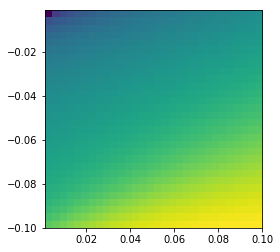

In [42]:
#Now, display it.
print 'Biggest expansion:' + str(np.max(cs))
print 'Biggest reverse expansion:' + str(np.min(cs))
print 'Biggest contraction:' + str(np.min(np.fabs(cs)))
print 'Typical contraction:' + str(np.average(cs))

print 'On hyperbolicity:'
print np.max(Hs)
print np.min(Hs)

#fig = plt.figure()
#ax = fig.gca(projection='3d')
plt.imshow(cs[::1, ::-1], extent=(bound, 0.1, -0.1, 0-bound))
plt.show()

#Switch back to accuracy for future boxes
dt = 1e-4

### Conclusions

Numerics are hard.

There seem to be multiple lines where strange effects happen; my diagrams are always criss-crossed with such lines.

I do not think this method will easily lend itself to good bounds on Hausdorff dimension, but it was a fun exercise.

In [43]:
dt = 1e-6
"""
tests = [0.1, 0.01, 0.001, 0.0001]
xs = [np.array([x, 0 - x]) for x in tests]

ys = [Theta(x)[0] for x in xs]


for y in ys:
    print y

"""
#It will be really easy to find the where limit of the return map just following the unstable manifold of the origin:

y, t = Theta(np.array([-0.000001, 0, 0]))

print y
dt = 1e-6

z, t, path = Theta(y, True)
v = simple_DTheta(y)
print v
print np.linalg.det(v)
print z

v2 = simple_DTheta(z)
print np.linalg.det(v2)

[ 4.1389691   0.60087768]
[[0.8643082178849681 -0.18736235431582315]
 [0.08024947115270464 -0.016351685165894025]]
0.000902833982621
[ 4.82736308  2.85766062]
0.00019806363785


So, it appears we need to go out to $4.2$ to make sure we capture the important point.

Note: it appears that the path_DTheta algorithm performs poorly for small $dt$.

simple_DTheta gives a very different answer. I guess all the floating point roundings add up.


Last thing today: draw a scatterplot of the regions.

(30, 30, 2)
[ 4.80561953  2.85562826]
[ 4.73584874  2.84989272]


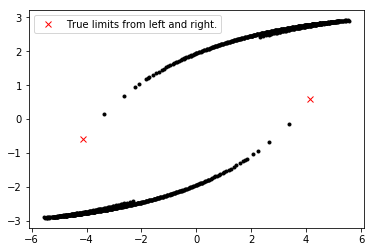

In [44]:
dt = 1e-3

q = 0 - z

X = np.linspace(-6, 6, 30)
Y = np.linspace(-3, 3, 30)

Zs = [[Theta((x, u))[0] for x in X] for u in Y]
print np.shape(Zs)
for row in Zs:
    for z in row:
        plt.plot([z[0]], [z[1]], 'k.')

y = np.array([ 4.1389691,  0.60087768]) #From before
q = Theta(y)[0]
print q
print Theta(q)[0]
plt.plot([y[0], -y[0]], [y[1], -y[1]], 'rx', label='True limits from left and right.')
#plt.plot([q[0], -q[0]], [q[1], -q[1]], 'b.', label="Images of limit points")
plt.legend()
plt.show()

In [45]:
p = np.array([y, 0-y])

for row in Zs:
    p = np.concatenate((p, row))
    
dt = 1e-4
print max([np.fabs(area_contraction(z)) for z in p])

0.0634568846658
